In [1]:
# import the necessary packages
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import cv2
import time
from torchvision import transforms
from torch import nn

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Assuming 'base_dir' is the path to the directory containing your four folders
base_dir = '/content/drive/MyDrive/MLProjectData/competition_data'
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Create a list to hold file paths and labels
image_paths = []
image_labels = []

# Map each class name to an integer label
label_dict = {class_name: index for index, class_name in enumerate(classes)}

# Go through each folder and add file paths and labels to the list
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.jpg'):
            image_paths.append(os.path.join(class_dir, file_name))
            image_labels.append(label_dict[class_name])


In [4]:
len(image_paths)
type(image_paths)

list

In [5]:
len(image_labels)
type(image_labels)

list

In [6]:
trial_image = cv2.imread(image_paths[5])

In [7]:
trial_image.shape

(256, 256, 3)

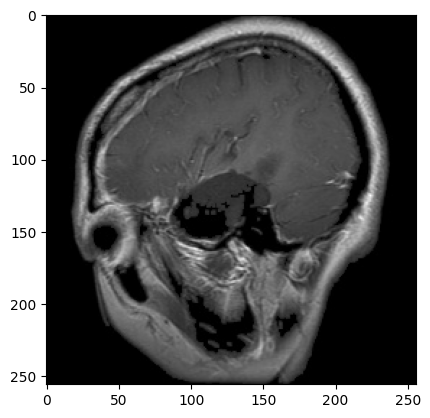

In [8]:
plt.imshow(trial_image)

In [9]:
class Configuration:

    TEST_SPLIT = 0.1

    device = "cuda" if torch.cuda.is_available() else "cpu"

    PIN_MEMORY = True if device == "cuda" else False

    NUM_CHANNELS = 3  # Number of channels in the image
    NUM_CLASSES = 4   # Number of classes for classification
    NUM_LEVELS = 3    # Depth of the UNet


    INIT_LR = 0.0001  # Initial learning rate
    NUM_EPOCHS = 40   # Number of epochs
    BATCH_SIZE = 32   # Number of samples in a batch

    INPUT_IMAGE_WIDTH = 256
    INPUT_IMAGE_HEIGHT = 256

    THRESHOLD = 0.5

configuration = Configuration()

In [10]:
class Segmentation(Dataset):
	def __init__(self, image_paths, labels, transforms):

		self.image_paths = image_paths
		self.labels = image_labels
		self.transforms = transforms

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		imagePath = self.image_paths[idx]

		image = cv2.imread(imagePath)
		# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		label = self.labels[idx]

		if self.transforms is not None:
			# apply the transformations to image
			image = self.transforms(image)

		return (image, label)

In [11]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)

	def forward(self, x):
		x = self.conv1(x)
		x = self.relu(x)
		x = self.conv2(x)
		return x
		# return self.conv2(self.relu(self.conv1(x)))

In [12]:
class encoderBlock(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()

		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):

		blockOutputs = []


		for block in self.encBlocks:

			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)


		return blockOutputs

In [13]:
class decoderBlock(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):

		for i in range(len(self.channels) - 1):

			x = self.upconvs[i](x)


			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)


		return x

	def crop(self, encFeatures, x):

		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)


		return encFeatures

In [14]:
class UNet(Module):
  def __init__(self, encChannels = (3, 16, 32, 64), decChannels = (64, 32, 16), nbClasses = 4, retainDim = True, outSize=(configuration.INPUT_IMAGE_HEIGHT,  configuration.INPUT_IMAGE_WIDTH)):
    super().__init__()

    self.encoder = encoderBlock(encChannels)
    self.decoder = decoderBlock(decChannels)


    self.head = self.head = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
        nn.Flatten(),  # Flatten the output
        nn.Linear(decChannels[-1], nbClasses))
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    encFeatures = self.encoder(x)
    decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])


    class_scores = self.head(decFeatures)

    return class_scores





### Define the data pipeline

In [15]:
split = train_test_split(image_paths, image_labels,
	test_size=configuration.TEST_SPLIT, random_state=42)

In [16]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]

In [17]:
trainDS = Segmentation(image_paths=trainImages, labels=trainLabels,
	transforms=transforms)

In [18]:
len(trainDS)

2227

In [19]:
from torchvision import transforms
from torch import nn


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(image_paths, image_labels,
	test_size=Configuration.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((Configuration.INPUT_IMAGE_HEIGHT,
		Configuration.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = Segmentation(image_paths=trainImages, labels=trainLabels,
	transforms=transforms)
testDS = Segmentation(image_paths=testImages, labels=testLabels,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 2227 examples in the training set...
[INFO] found 248 examples in the test set...


### Train the model

Training starts here for the network ...


  0%|          | 0/40 [00:00<?, ?it/s]

[INFO] EPOCH: 1/40
Train loss: 1.380173, Test loss: 1.1498
New best model found at epoch 1 with test loss 1.1498


  2%|▎         | 1/40 [02:52<1:52:12, 172.62s/it]

Train accuracy: 0.3251, Test accuracy: 1.0000


  5%|▌         | 2/40 [03:06<50:13, 79.29s/it]   

[INFO] EPOCH: 2/40
Train loss: 1.361259, Test loss: 1.3331
Train accuracy: 0.3318, Test accuracy: 0.0645


  8%|▊         | 3/40 [03:20<30:24, 49.31s/it]

[INFO] EPOCH: 3/40
Train loss: 1.360780, Test loss: 1.2791
Train accuracy: 0.3233, Test accuracy: 0.4073


 10%|█         | 4/40 [03:34<21:10, 35.29s/it]

[INFO] EPOCH: 4/40
Train loss: 1.359420, Test loss: 1.2738
Train accuracy: 0.3130, Test accuracy: 0.5403


 12%|█▎        | 5/40 [03:47<16:02, 27.51s/it]

[INFO] EPOCH: 5/40
Train loss: 1.360388, Test loss: 1.2719
Train accuracy: 0.3175, Test accuracy: 0.5000


 15%|█▌        | 6/40 [04:01<12:58, 22.88s/it]

[INFO] EPOCH: 6/40
Train loss: 1.359839, Test loss: 1.2948
Train accuracy: 0.3345, Test accuracy: 0.1331


 18%|█▊        | 7/40 [04:16<11:11, 20.34s/it]

[INFO] EPOCH: 7/40
Train loss: 1.359097, Test loss: 1.3534
Train accuracy: 0.3053, Test accuracy: 0.0000


 20%|██        | 8/40 [04:30<09:44, 18.26s/it]

[INFO] EPOCH: 8/40
Train loss: 1.359529, Test loss: 1.2266
Train accuracy: 0.3161, Test accuracy: 1.0000


 22%|██▎       | 9/40 [04:44<08:40, 16.80s/it]

[INFO] EPOCH: 9/40
Train loss: 1.358841, Test loss: 1.2641
Train accuracy: 0.3260, Test accuracy: 0.9798


 25%|██▌       | 10/40 [04:57<07:56, 15.88s/it]

[INFO] EPOCH: 10/40
Train loss: 1.358434, Test loss: 1.3706
Train accuracy: 0.3184, Test accuracy: 0.0000


 28%|██▊       | 11/40 [05:11<07:20, 15.18s/it]

[INFO] EPOCH: 11/40
Train loss: 1.358871, Test loss: 1.2516
Train accuracy: 0.3287, Test accuracy: 1.0000


 30%|███       | 12/40 [05:25<06:54, 14.80s/it]

[INFO] EPOCH: 12/40
Train loss: 1.358884, Test loss: 1.3235
Train accuracy: 0.3215, Test accuracy: 0.0000


 32%|███▎      | 13/40 [05:39<06:32, 14.52s/it]

[INFO] EPOCH: 13/40
Train loss: 1.358410, Test loss: 1.2724
Train accuracy: 0.3202, Test accuracy: 0.8629


 35%|███▌      | 14/40 [05:53<06:14, 14.39s/it]

[INFO] EPOCH: 14/40
Train loss: 1.358545, Test loss: 1.2979
Train accuracy: 0.3251, Test accuracy: 0.0685


 38%|███▊      | 15/40 [06:07<05:56, 14.26s/it]

[INFO] EPOCH: 15/40
Train loss: 1.358105, Test loss: 1.2839
Train accuracy: 0.3269, Test accuracy: 0.3790


 40%|████      | 16/40 [06:21<05:40, 14.18s/it]

[INFO] EPOCH: 16/40
Train loss: 1.356976, Test loss: 1.2097
Train accuracy: 0.3327, Test accuracy: 0.9677


 42%|████▎     | 17/40 [06:35<05:23, 14.06s/it]

[INFO] EPOCH: 17/40
Train loss: 1.357488, Test loss: 1.3007
Train accuracy: 0.3166, Test accuracy: 0.1935


 45%|████▌     | 18/40 [06:49<05:08, 14.03s/it]

[INFO] EPOCH: 18/40
Train loss: 1.357802, Test loss: 1.3277
Train accuracy: 0.3166, Test accuracy: 0.0121


 48%|████▊     | 19/40 [07:03<04:54, 14.02s/it]

[INFO] EPOCH: 19/40
Train loss: 1.358008, Test loss: 1.3074
Train accuracy: 0.3256, Test accuracy: 0.1290


 50%|█████     | 20/40 [07:17<04:39, 14.00s/it]

[INFO] EPOCH: 20/40
Train loss: 1.357648, Test loss: 1.3257
Train accuracy: 0.3220, Test accuracy: 0.0403


 52%|█████▎    | 21/40 [07:31<04:25, 14.00s/it]

[INFO] EPOCH: 21/40
Train loss: 1.357025, Test loss: 1.2740
Train accuracy: 0.3309, Test accuracy: 0.6573


 55%|█████▌    | 22/40 [07:45<04:12, 14.02s/it]

[INFO] EPOCH: 22/40
Train loss: 1.357046, Test loss: 1.2669
Train accuracy: 0.3193, Test accuracy: 0.7379


 57%|█████▊    | 23/40 [07:58<03:56, 13.92s/it]

[INFO] EPOCH: 23/40
Train loss: 1.357338, Test loss: 1.2006
Train accuracy: 0.3170, Test accuracy: 0.9355


 60%|██████    | 24/40 [08:12<03:42, 13.88s/it]

[INFO] EPOCH: 24/40
Train loss: 1.357521, Test loss: 1.3307
Train accuracy: 0.3395, Test accuracy: 0.0282


 62%|██████▎   | 25/40 [08:26<03:29, 13.94s/it]

[INFO] EPOCH: 25/40
Train loss: 1.357057, Test loss: 1.3386
Train accuracy: 0.3296, Test accuracy: 0.0484


 65%|██████▌   | 26/40 [08:40<03:14, 13.92s/it]

[INFO] EPOCH: 26/40
Train loss: 1.357824, Test loss: 1.3308
Train accuracy: 0.3175, Test accuracy: 0.0726


 68%|██████▊   | 27/40 [08:54<03:01, 13.96s/it]

[INFO] EPOCH: 27/40
Train loss: 1.357224, Test loss: 1.3069
Train accuracy: 0.3305, Test accuracy: 0.2621


 70%|███████   | 28/40 [09:08<02:47, 13.97s/it]

[INFO] EPOCH: 28/40
Train loss: 1.356913, Test loss: 1.2945
Train accuracy: 0.3318, Test accuracy: 0.4073


 72%|███████▎  | 29/40 [09:22<02:32, 13.87s/it]

[INFO] EPOCH: 29/40
Train loss: 1.357613, Test loss: 1.2800
Train accuracy: 0.3273, Test accuracy: 0.5726


 75%|███████▌  | 30/40 [09:36<02:18, 13.84s/it]

[INFO] EPOCH: 30/40
Train loss: 1.357108, Test loss: 1.2940
Train accuracy: 0.3327, Test accuracy: 0.5242


 78%|███████▊  | 31/40 [09:50<02:05, 13.90s/it]

[INFO] EPOCH: 31/40
Train loss: 1.357195, Test loss: 1.3069
Train accuracy: 0.3377, Test accuracy: 0.3387


 80%|████████  | 32/40 [10:03<01:50, 13.84s/it]

[INFO] EPOCH: 32/40
Train loss: 1.357460, Test loss: 1.2892
Train accuracy: 0.3354, Test accuracy: 0.5484


 82%|████████▎ | 33/40 [10:17<01:36, 13.79s/it]

[INFO] EPOCH: 33/40
Train loss: 1.356351, Test loss: 1.2947
Train accuracy: 0.3314, Test accuracy: 0.3992


 85%|████████▌ | 34/40 [10:31<01:23, 13.89s/it]

[INFO] EPOCH: 34/40
Train loss: 1.356510, Test loss: 1.3957
Train accuracy: 0.3435, Test accuracy: 0.0000


 88%|████████▊ | 35/40 [10:45<01:09, 13.90s/it]

[INFO] EPOCH: 35/40
Train loss: 1.357062, Test loss: 1.2967
Train accuracy: 0.3206, Test accuracy: 0.3589


 90%|█████████ | 36/40 [10:59<00:55, 13.85s/it]

[INFO] EPOCH: 36/40
Train loss: 1.357106, Test loss: 1.3150
Train accuracy: 0.3341, Test accuracy: 0.1774


 92%|█████████▎| 37/40 [11:13<00:41, 13.90s/it]

[INFO] EPOCH: 37/40
Train loss: 1.357527, Test loss: 1.2089
Train accuracy: 0.3300, Test accuracy: 0.9153


 95%|█████████▌| 38/40 [11:27<00:27, 13.96s/it]

[INFO] EPOCH: 38/40
Train loss: 1.356345, Test loss: 1.3366
Train accuracy: 0.3449, Test accuracy: 0.0726


 98%|█████████▊| 39/40 [11:41<00:13, 13.92s/it]

[INFO] EPOCH: 39/40
Train loss: 1.357749, Test loss: 1.3680
Train accuracy: 0.3336, Test accuracy: 0.0081


100%|██████████| 40/40 [11:55<00:00, 17.88s/it]

[INFO] EPOCH: 40/40
Train loss: 1.357584, Test loss: 1.2974
Train accuracy: 0.3260, Test accuracy: 0.3750
Time taken to train the model: 715.09s


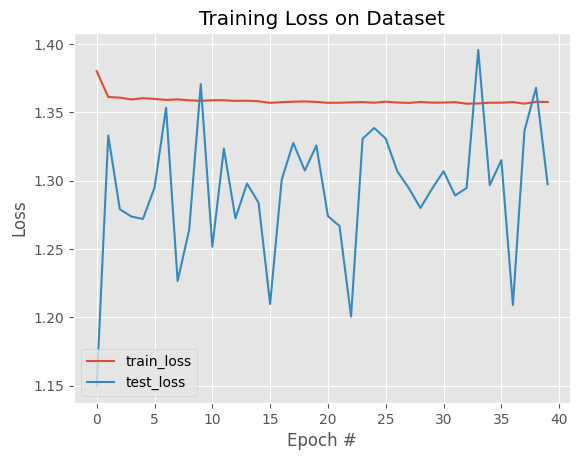

In [20]:
# initialize our UNet model
unet = UNet().to(configuration.device)

lossFunc = nn.CrossEntropyLoss()    # CrossEntropy as it is a multi class classificiation
opt = Adam(unet.parameters(), lr=configuration.INIT_LR)


trainSteps = len(trainDS) // configuration.BATCH_SIZE
testSteps = len(testDS) // configuration.BATCH_SIZE
best_val_loss = float('inf')
best_epoch = 0
best_model_path_1 = '/content/drive/MyDrive/MLProjectData/unet_best_model.pth'

H = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}


print("Training starts here for the network ...")
startTime = time.time()
for e in tqdm(range(configuration.NUM_EPOCHS)):

	unet.train()


	totalTrainLoss = 0
	totalTestLoss = 0
	trainCorrect = 0
	trainTotal = 0
	testCorrect = 0
	testTotal = 0


	for (i, (x, y)) in enumerate(trainLoader):

		(x, y) = (x.to(configuration.device), y.to(configuration.device))

		pred = unet(x)
		loss = lossFunc(pred, y.long())


		_, predictions = torch.max(pred, 1)
		trainCorrect += (predictions == y).sum().item()
		trainTotal += y.size(0)


		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

	trainAcc = trainCorrect / trainTotal
	H["train_acc"].append(trainAcc)

	with torch.no_grad():

		unet.eval()

		for (x, y) in testLoader:
			(x, y) = (x.to(configuration.device), y.to(configuration.device))

			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)

			_, predictions = torch.max(pred, 1)
			testCorrect += (predictions == y).sum().item()
			testTotal += y.size(0)

	testAcc = testCorrect / testTotal
	H["test_acc"].append(testAcc)

	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps


	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())


	print("[INFO] EPOCH: {}/{}".format(e + 1, Configuration.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
	avgTestLoss = totalTestLoss / testSteps
	if avgTestLoss < best_val_loss:
		print(f"New best model found at epoch {e+1} with test loss {avgTestLoss:.4f}")
		best_val_loss = avgTestLoss
		best_epoch = e + 1
		# best_model_save_path = os.path.join('/content/drive/MyDrive/MLProjectData', f'unet_best_model_epoch_{best_epoch}.pth')
		torch.save(unet.state_dict(), best_model_path_1)

	print(f"Train accuracy: {trainAcc:.4f}, Test accuracy: {testAcc:.4f}")

endTime = time.time()
print("Time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")



### Predict using the trained model

In [21]:
def make_predictions(model, image_path, classLabels):
    # set model to evaluation mode
    model.eval()

    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (configuration.INPUT_IMAGE_WIDTH, configuration.INPUT_IMAGE_HEIGHT))
        image = image.astype("float32") / 255.0

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(Configuration.device)

        # make the prediction and retrieve the index of the highest
        # score to find the predicted class label
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predictedClass = preds.cpu().numpy()[0]

    # return the original image and the predicted class label
    return image, classLabels[predictedClass]


In [22]:
# Assuming 'base_dir' is the path to the directory containing your four folders
base_dir_2 = '/content/drive/MyDrive/MLProjectData/kaggle_solutionSet'
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Create a list to hold file paths and labels
kaggle_image_paths = []

for file_name in os.listdir(base_dir_2):
    if file_name.endswith('.jpg'):
        kaggle_image_paths.append(os.path.join(base_dir_2, file_name))




In [23]:
len(kaggle_image_paths)

621

In [24]:
import pandas as pd

# Assuming `testImages` is a list of file paths in your test set
# and `classLabels` is a list or dict mapping class indices to class names

# Initialize a list to store image names and predicted class names
predictions = []

# Loop over the test images
for imagePath in kaggle_image_paths:
    # Extract the image file name
    imageFileName = imagePath.split(os.path.sep)[-1]

    # Make a prediction using the model
    _, predictedClass = make_predictions(unet, imagePath, classes)

    # Store the result
    predictions.append([imageFileName, predictedClass])

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['ID', 'prediction'])

# Save the predictions to a CSV file
predictions_csv_path = '/content/drive/MyDrive/MLProjectData/predictions.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"Predictions saved to {predictions_csv_path}")


Predictions saved to /content/drive/MyDrive/MLProjectData/predictions.csv


UNet with image augmentation

In [25]:
from torchvision import transforms
from torch import nn


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(image_paths, image_labels,
	test_size=Configuration.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((Configuration.INPUT_IMAGE_HEIGHT,
		Configuration.INPUT_IMAGE_WIDTH)),
	transforms.RandomRotation(degrees=10),
	transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = Segmentation(image_paths=trainImages, labels=trainLabels,
	transforms=transforms)
testDS = Segmentation(image_paths=testImages, labels=testLabels,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 2227 examples in the training set...
[INFO] found 248 examples in the test set...


Training starts here for the network ...


  2%|▎         | 1/40 [00:14<09:28, 14.58s/it]

[INFO] EPOCH: 1/40
Train loss: 1.423439, Test loss: 1.2846
Train accuracy: 0.1940, Test accuracy: 0.0000
New best model found at epoch 1 with test loss 1.2846


  5%|▌         | 2/40 [00:29<09:21, 14.79s/it]

[INFO] EPOCH: 2/40
Train loss: 1.361374, Test loss: 1.3096
Train accuracy: 0.3282, Test accuracy: 0.9637


  8%|▊         | 3/40 [00:44<09:09, 14.85s/it]

[INFO] EPOCH: 3/40
Train loss: 1.359974, Test loss: 1.2857
Train accuracy: 0.3170, Test accuracy: 0.0000


 10%|█         | 4/40 [00:59<08:51, 14.77s/it]

[INFO] EPOCH: 4/40
Train loss: 1.359247, Test loss: 1.2718
Train accuracy: 0.3273, Test accuracy: 0.0000
New best model found at epoch 4 with test loss 1.2718


 12%|█▎        | 5/40 [01:13<08:33, 14.66s/it]

[INFO] EPOCH: 5/40
Train loss: 1.359446, Test loss: 1.3044
Train accuracy: 0.3125, Test accuracy: 0.0323


 15%|█▌        | 6/40 [01:27<08:11, 14.45s/it]

[INFO] EPOCH: 6/40
Train loss: 1.359565, Test loss: 1.3116
Train accuracy: 0.3197, Test accuracy: 0.3952


 18%|█▊        | 7/40 [01:42<07:57, 14.48s/it]

[INFO] EPOCH: 7/40
Train loss: 1.359094, Test loss: 1.2981
Train accuracy: 0.3125, Test accuracy: 0.0323


 20%|██        | 8/40 [01:56<07:42, 14.46s/it]

[INFO] EPOCH: 8/40
Train loss: 1.361765, Test loss: 1.2690
Train accuracy: 0.3278, Test accuracy: 0.0000
New best model found at epoch 8 with test loss 1.2690


 22%|██▎       | 9/40 [02:11<07:33, 14.62s/it]

[INFO] EPOCH: 9/40
Train loss: 1.357468, Test loss: 1.2269
Train accuracy: 0.3107, Test accuracy: 1.0000
New best model found at epoch 9 with test loss 1.2269


 25%|██▌       | 10/40 [02:26<07:21, 14.72s/it]

[INFO] EPOCH: 10/40
Train loss: 1.357941, Test loss: 1.3496
Train accuracy: 0.3278, Test accuracy: 0.0000


 28%|██▊       | 11/40 [02:41<07:05, 14.69s/it]

[INFO] EPOCH: 11/40
Train loss: 1.361378, Test loss: 1.2649
Train accuracy: 0.3278, Test accuracy: 0.0000


 30%|███       | 12/40 [02:55<06:48, 14.60s/it]

[INFO] EPOCH: 12/40
Train loss: 1.359679, Test loss: 1.3385
Train accuracy: 0.3220, Test accuracy: 0.0000


 32%|███▎      | 13/40 [03:09<06:33, 14.56s/it]

[INFO] EPOCH: 13/40
Train loss: 1.358639, Test loss: 1.2896
Train accuracy: 0.3278, Test accuracy: 0.0000


 35%|███▌      | 14/40 [03:23<06:13, 14.36s/it]

[INFO] EPOCH: 14/40
Train loss: 1.358469, Test loss: 1.2150
Train accuracy: 0.3269, Test accuracy: 1.0000
New best model found at epoch 14 with test loss 1.2150


 38%|███▊      | 15/40 [03:38<05:59, 14.37s/it]

[INFO] EPOCH: 15/40
Train loss: 1.359173, Test loss: 1.2781
Train accuracy: 0.3220, Test accuracy: 0.0000


 40%|████      | 16/40 [03:52<05:44, 14.36s/it]

[INFO] EPOCH: 16/40
Train loss: 1.359967, Test loss: 1.3116
Train accuracy: 0.3233, Test accuracy: 0.0000


 42%|████▎     | 17/40 [04:07<05:35, 14.57s/it]

[INFO] EPOCH: 17/40
Train loss: 1.359138, Test loss: 1.2635
Train accuracy: 0.3287, Test accuracy: 1.0000


 45%|████▌     | 18/40 [04:22<05:24, 14.74s/it]

[INFO] EPOCH: 18/40
Train loss: 1.359956, Test loss: 1.3110
Train accuracy: 0.3134, Test accuracy: 0.8185


 48%|████▊     | 19/40 [04:37<05:09, 14.72s/it]

[INFO] EPOCH: 19/40
Train loss: 1.357939, Test loss: 1.3095
Train accuracy: 0.3220, Test accuracy: 0.0000


 50%|█████     | 20/40 [04:52<04:55, 14.80s/it]

[INFO] EPOCH: 20/40
Train loss: 1.358023, Test loss: 1.2543
Train accuracy: 0.3269, Test accuracy: 0.8589


 52%|█████▎    | 21/40 [05:07<04:40, 14.78s/it]

[INFO] EPOCH: 21/40
Train loss: 1.357926, Test loss: 1.2575
Train accuracy: 0.3211, Test accuracy: 0.8710


 55%|█████▌    | 22/40 [05:21<04:21, 14.55s/it]

[INFO] EPOCH: 22/40
Train loss: 1.357942, Test loss: 1.3306
Train accuracy: 0.3264, Test accuracy: 0.0000


 57%|█████▊    | 23/40 [05:35<04:07, 14.53s/it]

[INFO] EPOCH: 23/40
Train loss: 1.359185, Test loss: 1.2806
Train accuracy: 0.3278, Test accuracy: 0.0000


 60%|██████    | 24/40 [05:50<03:52, 14.53s/it]

[INFO] EPOCH: 24/40
Train loss: 1.358778, Test loss: 1.2849
Train accuracy: 0.3211, Test accuracy: 0.6532


 62%|██████▎   | 25/40 [06:05<03:39, 14.63s/it]

[INFO] EPOCH: 25/40
Train loss: 1.358373, Test loss: 1.3011
Train accuracy: 0.3327, Test accuracy: 0.0000


 65%|██████▌   | 26/40 [06:19<03:25, 14.71s/it]

[INFO] EPOCH: 26/40
Train loss: 1.358780, Test loss: 1.3118
Train accuracy: 0.3278, Test accuracy: 0.0000


 68%|██████▊   | 27/40 [06:34<03:12, 14.77s/it]

[INFO] EPOCH: 27/40
Train loss: 1.358144, Test loss: 1.3080
Train accuracy: 0.3251, Test accuracy: 0.0000


 70%|███████   | 28/40 [06:49<02:57, 14.77s/it]

[INFO] EPOCH: 28/40
Train loss: 1.358408, Test loss: 1.2752
Train accuracy: 0.3278, Test accuracy: 0.0000


 72%|███████▎  | 29/40 [07:04<02:42, 14.76s/it]

[INFO] EPOCH: 29/40
Train loss: 1.357854, Test loss: 1.3315
Train accuracy: 0.3256, Test accuracy: 0.8629


 75%|███████▌  | 30/40 [07:18<02:26, 14.66s/it]

[INFO] EPOCH: 30/40
Train loss: 1.357802, Test loss: 1.3089
Train accuracy: 0.3220, Test accuracy: 0.0000


 78%|███████▊  | 31/40 [07:33<02:10, 14.53s/it]

[INFO] EPOCH: 31/40
Train loss: 1.358399, Test loss: 1.3073
Train accuracy: 0.3247, Test accuracy: 0.0000


 80%|████████  | 32/40 [07:47<01:55, 14.48s/it]

[INFO] EPOCH: 32/40
Train loss: 1.358647, Test loss: 1.2796
Train accuracy: 0.3287, Test accuracy: 0.5847


 82%|████████▎ | 33/40 [08:02<01:41, 14.57s/it]

[INFO] EPOCH: 33/40
Train loss: 1.357239, Test loss: 1.3282
Train accuracy: 0.3233, Test accuracy: 0.4395


 85%|████████▌ | 34/40 [08:17<01:28, 14.70s/it]

[INFO] EPOCH: 34/40
Train loss: 1.358016, Test loss: 1.2946
Train accuracy: 0.3229, Test accuracy: 0.5766


 88%|████████▊ | 35/40 [08:32<01:14, 14.88s/it]

[INFO] EPOCH: 35/40
Train loss: 1.358062, Test loss: 1.3157
Train accuracy: 0.3112, Test accuracy: 0.8065


 90%|█████████ | 36/40 [08:46<00:59, 14.77s/it]

[INFO] EPOCH: 36/40
Train loss: 1.357833, Test loss: 1.2627
Train accuracy: 0.3368, Test accuracy: 0.8306


 92%|█████████▎| 37/40 [09:01<00:44, 14.77s/it]

[INFO] EPOCH: 37/40
Train loss: 1.358015, Test loss: 1.3393
Train accuracy: 0.3287, Test accuracy: 0.0242


 95%|█████████▌| 38/40 [09:16<00:29, 14.64s/it]

[INFO] EPOCH: 38/40
Train loss: 1.357968, Test loss: 1.3705
Train accuracy: 0.3291, Test accuracy: 0.0766


 98%|█████████▊| 39/40 [09:30<00:14, 14.52s/it]

[INFO] EPOCH: 39/40
Train loss: 1.358397, Test loss: 1.2786
Train accuracy: 0.3368, Test accuracy: 0.6935


100%|██████████| 40/40 [09:44<00:00, 14.62s/it]

[INFO] EPOCH: 40/40
Train loss: 1.356936, Test loss: 1.2994
Train accuracy: 0.3368, Test accuracy: 0.3790
Time taken to train the model: 584.81s


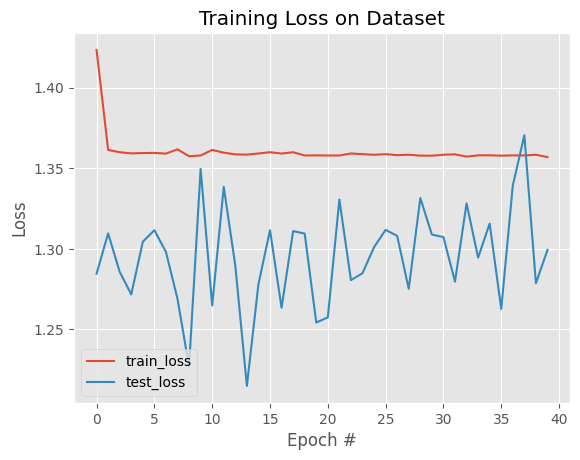

In [26]:
# initialize our UNet model
unet2 = UNet().to(configuration.device)

lossFunc = nn.CrossEntropyLoss()    # CrossEntropy as it is a multi class classificiation
opt = Adam(unet2.parameters(), lr=configuration.INIT_LR)


trainSteps = len(trainDS) // configuration.BATCH_SIZE
testSteps = len(testDS) // configuration.BATCH_SIZE
best_val_loss = float('inf')
best_epoch = 0
best_model_path = '/content/drive/MyDrive/MLProjectData/unet1_best_model.pth'

H = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}


print("Training starts here for the network ...")
startTime = time.time()
for e in tqdm(range(configuration.NUM_EPOCHS)):

	unet2.train()


	totalTrainLoss = 0
	totalTestLoss = 0
	trainCorrect = 0
	trainTotal = 0
	testCorrect = 0
	testTotal = 0


	for (i, (x, y)) in enumerate(trainLoader):

		(x, y) = (x.to(configuration.device), y.to(configuration.device))

		pred = unet2(x)
		loss = lossFunc(pred, y.long())


		_, predictions = torch.max(pred, 1)
		trainCorrect += (predictions == y).sum().item()
		trainTotal += y.size(0)


		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

	trainAcc = trainCorrect / trainTotal
	H["train_acc"].append(trainAcc)

	with torch.no_grad():

		unet2.eval()

		for (x, y) in testLoader:
			(x, y) = (x.to(configuration.device), y.to(configuration.device))

			pred = unet2(x)
			totalTestLoss += lossFunc(pred, y)

			_, predictions = torch.max(pred, 1)
			testCorrect += (predictions == y).sum().item()
			testTotal += y.size(0)


	testAcc = testCorrect / testTotal
	H["test_acc"].append(testAcc)

	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps


	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())


	print("[INFO] EPOCH: {}/{}".format(e + 1, Configuration.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

	print(f"Train accuracy: {trainAcc:.4f}, Test accuracy: {testAcc:.4f}")

	avgTestLoss = totalTestLoss / testSteps
	if avgTestLoss < best_val_loss:
		print(f"New best model found at epoch {e+1} with test loss {avgTestLoss:.4f}")
		best_val_loss = avgTestLoss
		best_epoch = e + 1
		# best_model_save_path = os.path.join('/content/drive/MyDrive/MLProjectData', f'unet_best_model_epoch_{best_epoch}.pth')
		torch.save(unet2.state_dict(), best_model_path)


endTime = time.time()
print("Time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")



In [27]:
# Define the path to the saved model state
saved_model_state_path = '/content/drive/MyDrive/MLProjectData/unet_best_model.pth'

# Initialize your UNet model
unet2 = UNet().to(Configuration.device)

# Load the saved model state
unet2.load_state_dict(torch.load(saved_model_state_path))

# Make sure to switch to evaluation mode
unet2.eval()

UNet(
  (encoder): encoderBlock(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): decoderBlock(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(

In [28]:
def make_predictions(model, image_path, classLabels):
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (configuration.INPUT_IMAGE_WIDTH, configuration.INPUT_IMAGE_HEIGHT))
        image = image.astype("float32") / 255.0

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(Configuration.device)

        # make the prediction and retrieve the index of the highest
        # score to find the predicted class label
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predictedClass = preds.cpu().numpy()[0]

    # return the original image and the predicted class label
    return image, classLabels[predictedClass]


In [29]:
import pandas as pd

# Assuming `testImages` is a list of file paths in your test set
# and `classLabels` is a list or dict mapping class indices to class names

# Initialize a list to store image names and predicted class names
predictions = []

# Loop over the test images
for imagePath in kaggle_image_paths:
    # Extract the image file name
    imageFileName = imagePath.split(os.path.sep)[-1]

    # Make a prediction using the model
    _, predictedClass = make_predictions(unet2, imagePath, classes)

    # Store the result
    predictions.append([imageFileName, predictedClass])

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['ID', 'prediction'])

# Save the predictions to a CSV file
predictions_csv_path = '/content/drive/MyDrive/MLProjectData/predictions2.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"Predictions saved to {predictions_csv_path}")


Predictions saved to /content/drive/MyDrive/MLProjectData/predictions2.csv
